# Bagmati catchment
# 3. GRU
### Hyperband class

# Hyperparameter tuning using model_builder function from tensorflow   (Standard normalization)
(After midterm)
#(https://www.tensorflow.org/tutorials/keras/keras_tuner)

In [1]:
import numpy as np
import pandas as pd

### define file path
path = 'Non_scaled_6_input_Bagmati_yr.csv'  ####### This excel data is not scaled/normalized
## Read CSV file and convert it to dataframe
df = pd.read_csv( path, sep = ',', header = 'infer')


In [2]:
df

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
0,0.878,25.060,3.613,8.190,1.608,28.160,299.0
1,0.000,0.878,25.060,3.613,8.190,1.608,182.0
2,25.527,0.000,0.878,25.060,3.613,8.190,151.0
3,36.896,25.527,0.000,0.878,25.060,3.613,561.0
4,6.184,36.896,25.527,0.000,0.878,25.060,384.0
...,...,...,...,...,...,...,...
2909,7.115,0.422,7.130,13.781,4.314,18.381,132.0
2910,3.118,7.115,0.422,7.130,13.781,4.314,107.0
2911,61.877,3.118,7.115,0.422,7.130,13.781,538.0
2912,112.900,61.877,3.118,7.115,0.422,7.130,921.0


In [3]:
df.describe()

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
count,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000
mean,5.433136,5.434821,5.397316,5.378893,5.378374,5.385596,149.648264
std,14.030448,14.032511,13.890520,13.851130,13.851243,13.857633,271.208820
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.100000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.800000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.700000
75%,4.916000,4.916000,4.864500,4.864500,4.864500,4.864500,195.975000
max,364.590000,364.590000,364.590000,364.590000,364.590000,364.590000,5030.000000


# 1. Data splitting

##  Train, Validation and Test data 
###  70% train (2040 data points)
###  15% train (436 data points)
###  15% train (436 data points)

In [4]:
df_train = df.iloc[:2040]

df_val = df.iloc[2040:2476] 

df_test = df.iloc[2476:2912] 

# 2. Normalization

In [5]:
import pandas as pd
import numpy as np

### General function for all the normalization methods

def normalize_df(data, norm_method):     

    ## Normalize data using specified method
 
    if norm_method == 'minmax':
        # Min-Max normalization
        data = (data - data.min()) / (data.max() - data.min())
    elif norm_method == 'zscore':
        # Z-score normalization
        mean = data.mean()
        std = data.std()
        data = (data - mean) / std
    elif norm_method == 'max':
        # Max normalization
        data = 1 - ((data.max() - data)/data.max())
    else:
        raise ValueError("Invalid normalization method. Choose from: 'minmax', 'zscore', 'max'")
    return data



### Standard normalization  (Date sets for training, validation and testing are nromalized separately)

In [6]:
## Z_score(standard)
df_train_norm = normalize_df(df_train, 'zscore')
df_val_norm = normalize_df(df_val, 'zscore')
df_test_norm = normalize_df(df_test, 'zscore')

In [7]:
###example
df_train_norm.describe()

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
count,2.040000e+03,2.040000e+03,2.040000e+03,2.040000e+03,2.040000e+03,2.040000e+03,2.040000e+03
mean,-2.590520e-17,5.329615e-16,-1.793772e-16,5.066753e-17,2.870797e-16,-2.443579e-17,2.166023e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.668091e-01,-3.674980e-01,-3.676080e-01,-3.678887e-01,-3.679488e-01,-3.686857e-01,-5.277226e-01
25%,-3.668091e-01,-3.674980e-01,-3.676080e-01,-3.678887e-01,-3.679488e-01,-3.686857e-01,-4.900124e-01
50%,-3.668091e-01,-3.674980e-01,-3.676080e-01,-3.678887e-01,-3.679488e-01,-3.686857e-01,-3.891311e-01
75%,-5.646773e-02,-5.666901e-02,-5.677197e-02,-5.549026e-02,-5.554508e-02,-5.307515e-02,1.998830e-01
max,2.456513e+01,2.455419e+01,2.455464e+01,2.455494e+01,2.455530e+01,2.454060e+01,1.705836e+01


In [8]:
### convert the dataframes to numpy arrays

df_train_f = df_train_norm.to_numpy()

df_val_f = df_val_norm.to_numpy()

df_test_f = df_test_norm.to_numpy()

In [9]:
### Define input and output sequences (list of sub sequences)

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
    # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1] 
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 1, 1    ####  input sequences and  output sequences



### Split into input and target variables

In [10]:
#### Training data


X_train, y_train = split_sequences(df_train_f, n_steps_in, n_steps_out)
print(X_train.shape, y_train.shape)

# reshape from [samples, timesteps] into [samples, timesteps, features]

n_features = 6

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
print(X_train.shape)


(2040, 1, 6) (2040, 1)
(2040, 1, 6)


In [11]:
#### validation data

X_val, y_val = split_sequences(df_val_f , n_steps_in, n_steps_out)


X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

### reshape

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

print(X_val.shape, y_val.shape)


(436, 1, 6) (436, 1)


In [12]:
#### Test data

X_test, y_test = split_sequences(df_test_f , n_steps_in, n_steps_out)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

print(X_test.shape, y_test.shape)


(436, 1, 6) (436, 1)


In [13]:
#### model fitting
import keras
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import save_model

from tensorflow.keras import initializers

from tensorflow.keras import layers


## Hyperparameter tuning using KerasTuner

In [14]:

import keras_tuner as kt


from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner.engine.hyperparameters import Choice,Float

### a. Define model (Using model_buider function)
### (https://www.tensorflow.org/tutorials/keras/keras_tuner)
## GRU

In [15]:
def model_builder(hp):
    model = keras.Sequential()
    ###1. tune the units
    
    hp_units = hp.Int('units', min_value = 1, max_value = 10, step = 1)
    
    ###2. tune weight initialization
    hp_initializer=hp.Choice('weight_init', ['he_uniform', 'glorot_uniform', 'random_normal' , 'lecun_normal'])
    
    ###3. tune activation function
    hp_activation = hp.Choice("activation", ["relu", "tanh", "sigmoid"]) 
    
    ### Fix the seeds for reproducibility purposes     
    if hp_initializer == 'he_uniform':
        init = tf.keras.initializers.he_uniform(seed=1)
    elif hp_initializer == 'glorot_uniform':
        init = tf.keras.initializers.glorot_uniform(seed=1)
    elif hp_initializer == 'random_normal':
        init = tf.keras.initializers.RandomNormal(seed=1)
    else:
        init = tf.keras.initializers.lecun_normal(seed=1)
   

     ##4. Tune number of layers
    ## 5. Tune dropout rates
    for i in range(hp.Int("num_layers", 1, 3)):
        
        model.add(keras.layers.GRU(units=hp_units,
                                activation = hp_activation,
                                return_sequences=True,
                                kernel_initializer = init))
        model.add(Dropout(hp.Float('dropout_rate', 0, 0.3, step=0.1)))
        
#     model.add(keras.layers.LSTM(units=hp.Int('units', min_value=1, max_value=10, step=1),
#                                 kernel_initializer = hp.Choice('weight_init', ['he_uniform', 'glorot_uniform', 'random_normal' , 'lecun_normal'])))
#     model.add(Dropout(hp.Float('dropout_rate', 0, 0.3, step=0.1)))
    
    model.add(keras.layers.Dense(1, kernel_initializer = init))
    ##6. Tune optimizer
    hp_optimizer = hp.Choice("optimizer", ['Adam', 'SGD', 'RMSprop'])

    model.compile (optimizer = hp_optimizer, 
                   loss='mean_squared_error',
                   metrics=[tf.keras.metrics.MeanSquaredError()])
    
    return model

### b.  Instantiate the tuner and perform hypertuning

In [16]:
#### Hyperband tuner ( it is a class)

tuner = kt.Hyperband(model_builder,
                     
                     objective= 'mean_squared_error',  ### should be the same as the loss funtion used when compiling
                     
                     max_epochs = 20,
                     
                     factor=2,  
                     
                     seed = 10,
                     
                     directory='Exhaustive_Opt_norm',
                     
                     project_name='Test_2_GRU_hyperband')

In [17]:
from keras.callbacks import TensorBoard

import datetime, os

log_dir = "Exhaustive_Opt_norm/Test_2_GRU_hyperband'/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")   ### for the purpose of TensorBoard visualization


In [18]:
#tb = TensorBoard(log_dir=log_dir)
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [19]:
### Create a callback to stop training early after reaching a certain value for the validation loss.

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### C. Run hyperparameter search 

# 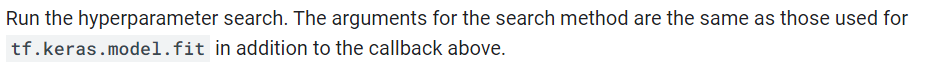

In [20]:
tuner.search(X_train, y_train, 
             epochs=200, 
             validation_data=(X_val, y_val), 
             callbacks=[stop_early,tb])

Trial 92 Complete [00h 00m 14s]
mean_squared_error: 0.6240188479423523

Best mean_squared_error So Far: 0.15248215198516846
Total elapsed time: 00h 20m 04s
INFO:tensorflow:Oracle triggered exit


In [21]:
tuner.results_summary()

Results summary
Results in Exhaustive_Opt_norm\Test_2_GRU_hyperband
Showing 10 best trials
Trial summary
Hyperparameters:
units: 7
weight_init: random_normal
activation: relu
num_layers: 2
dropout_rate: 0.0
optimizer: Adam
tuner/epochs: 20
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0059
Score: 0.15248215198516846
Trial summary
Hyperparameters:
units: 8
weight_init: glorot_uniform
activation: relu
num_layers: 3
dropout_rate: 0.0
optimizer: SGD
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.1577644944190979
Trial summary
Hyperparameters:
units: 7
weight_init: random_normal
activation: relu
num_layers: 2
dropout_rate: 0.0
optimizer: Adam
tuner/epochs: 10
tuner/initial_epoch: 5
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0054
Score: 0.1960672289133072
Trial summary
Hyperparameters:
units: 10
weight_init: glorot_uniform
activation: relu
num_layers: 1
dropout_rate: 0.2
optimizer: SGD
tuner/epochs: 20
tuner/initial_epoch: 10
t

In [22]:
%load_ext tensorboard

In [23]:
%tensorboard --logdir AMT_Exhaustive_optimization/Test1

## d.  get the optimal hyperparameters

In [24]:

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]



print(f"""
The hyperparameter search is complete. 

The optimal number of units in the first densely-connected layer is {best_hps.get('units')}, 
The optimal activation function is {best_hps.get('activation')},
The optimal weight initialization is {best_hps.get('weight_init')}
The optimal optimizer is {best_hps.get('optimizer')}.
The optimal number of layers is {best_hps.get('num_layers')},
The optimal dropout rate is {best_hps.get('dropout_rate')},

""")




The hyperparameter search is complete. 

The optimal number of units in the first densely-connected layer is 7, 
The optimal activation function is relu,
The optimal weight initialization is random_normal
The optimal optimizer is Adam.
The optimal number of layers is 2,
The optimal dropout rate is 0.0,




## e. Train the model using the best model

In [25]:
import random
random.seed(1)

tf.random.set_seed(1) 
model = tuner.hypermodel.build(best_hps)


In [26]:
### model training 
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

GRU_hp_1 = model.fit(X_train, y_train, epochs=300, validation_data = (X_val, y_val), shuffle = 0  )  ##callbacks=[early_stopping]


Epoch 1/300
64/64 [==============================] - 9s 22ms/step - loss: 0.9990 - mean_squared_error: 0.9990 - val_loss: 0.9947 - val_mean_squared_error: 0.9947
Epoch 2/300
64/64 [==============================] - 1s 9ms/step - loss: 0.9923 - mean_squared_error: 0.9923 - val_loss: 0.9801 - val_mean_squared_error: 0.9801
Epoch 3/300
64/64 [==============================] - 1s 10ms/step - loss: 0.9620 - mean_squared_error: 0.9620 - val_loss: 0.9215 - val_mean_squared_error: 0.9215
Epoch 4/300
64/64 [==============================] - 1s 10ms/step - loss: 0.8740 - mean_squared_error: 0.8740 - val_loss: 0.7781 - val_mean_squared_error: 0.7781
Epoch 5/300
64/64 [==============================] - 1s 11ms/step - loss: 0.7231 - mean_squared_error: 0.7231 - val_loss: 0.5919 - val_mean_squared_error: 0.5919
Epoch 6/300
64/64 [==============================] - 1s 11ms/step - loss: 0.5735 - mean_squared_error: 0.5735 - val_loss: 0.4689 - val_mean_squared_error: 0.4689
Epoch 7/300
64/64 [==========

64/64 [==============================] - 1s 9ms/step - loss: 0.1548 - mean_squared_error: 0.1548 - val_loss: 0.2971 - val_mean_squared_error: 0.2971
Epoch 52/300
64/64 [==============================] - 1s 9ms/step - loss: 0.1546 - mean_squared_error: 0.1546 - val_loss: 0.2970 - val_mean_squared_error: 0.2970
Epoch 53/300
64/64 [==============================] - 1s 8ms/step - loss: 0.1545 - mean_squared_error: 0.1545 - val_loss: 0.2969 - val_mean_squared_error: 0.2969
Epoch 54/300
64/64 [==============================] - 1s 10ms/step - loss: 0.1543 - mean_squared_error: 0.1543 - val_loss: 0.2968 - val_mean_squared_error: 0.2968
Epoch 55/300
64/64 [==============================] - 1s 11ms/step - loss: 0.1541 - mean_squared_error: 0.1541 - val_loss: 0.2967 - val_mean_squared_error: 0.2967
Epoch 56/300
64/64 [==============================] - 1s 10ms/step - loss: 0.1539 - mean_squared_error: 0.1539 - val_loss: 0.2965 - val_mean_squared_error: 0.2965
Epoch 57/300
64/64 [==================

64/64 [==============================] - 1s 10ms/step - loss: 0.1483 - mean_squared_error: 0.1483 - val_loss: 0.2950 - val_mean_squared_error: 0.2950
Epoch 102/300
64/64 [==============================] - 1s 10ms/step - loss: 0.1483 - mean_squared_error: 0.1483 - val_loss: 0.2951 - val_mean_squared_error: 0.2951
Epoch 103/300
64/64 [==============================] - 1s 11ms/step - loss: 0.1481 - mean_squared_error: 0.1481 - val_loss: 0.2950 - val_mean_squared_error: 0.2950
Epoch 104/300
64/64 [==============================] - 1s 11ms/step - loss: 0.1480 - mean_squared_error: 0.1480 - val_loss: 0.2950 - val_mean_squared_error: 0.2950
Epoch 105/300
64/64 [==============================] - 1s 12ms/step - loss: 0.1480 - mean_squared_error: 0.1480 - val_loss: 0.2951 - val_mean_squared_error: 0.2951
Epoch 106/300
64/64 [==============================] - 1s 13ms/step - loss: 0.1478 - mean_squared_error: 0.1478 - val_loss: 0.2950 - val_mean_squared_error: 0.2950
Epoch 107/300
64/64 [=========

64/64 [==============================] - 1s 9ms/step - loss: 0.1435 - mean_squared_error: 0.1435 - val_loss: 0.2954 - val_mean_squared_error: 0.2954
Epoch 152/300
64/64 [==============================] - 1s 10ms/step - loss: 0.1434 - mean_squared_error: 0.1434 - val_loss: 0.2954 - val_mean_squared_error: 0.2954
Epoch 153/300
64/64 [==============================] - 1s 9ms/step - loss: 0.1433 - mean_squared_error: 0.1433 - val_loss: 0.2954 - val_mean_squared_error: 0.2954
Epoch 154/300
64/64 [==============================] - 1s 9ms/step - loss: 0.1432 - mean_squared_error: 0.1432 - val_loss: 0.2954 - val_mean_squared_error: 0.2954
Epoch 155/300
64/64 [==============================] - 1s 8ms/step - loss: 0.1431 - mean_squared_error: 0.1431 - val_loss: 0.2954 - val_mean_squared_error: 0.2954
Epoch 156/300
64/64 [==============================] - 0s 8ms/step - loss: 0.1430 - mean_squared_error: 0.1430 - val_loss: 0.2954 - val_mean_squared_error: 0.2954
Epoch 157/300
64/64 [==============

64/64 [==============================] - 1s 8ms/step - loss: 0.1392 - mean_squared_error: 0.1392 - val_loss: 0.2948 - val_mean_squared_error: 0.2948
Epoch 202/300
64/64 [==============================] - 1s 9ms/step - loss: 0.1388 - mean_squared_error: 0.1388 - val_loss: 0.2945 - val_mean_squared_error: 0.2945
Epoch 203/300
64/64 [==============================] - 1s 10ms/step - loss: 0.1390 - mean_squared_error: 0.1390 - val_loss: 0.2947 - val_mean_squared_error: 0.2947
Epoch 204/300
64/64 [==============================] - 1s 10ms/step - loss: 0.1387 - mean_squared_error: 0.1387 - val_loss: 0.2945 - val_mean_squared_error: 0.2945
Epoch 205/300
64/64 [==============================] - 1s 8ms/step - loss: 0.1388 - mean_squared_error: 0.1388 - val_loss: 0.2947 - val_mean_squared_error: 0.2947
Epoch 206/300
64/64 [==============================] - 1s 9ms/step - loss: 0.1385 - mean_squared_error: 0.1385 - val_loss: 0.2943 - val_mean_squared_error: 0.2943
Epoch 207/300
64/64 [=============

64/64 [==============================] - 1s 8ms/step - loss: 0.1347 - mean_squared_error: 0.1347 - val_loss: 0.2930 - val_mean_squared_error: 0.2930
Epoch 252/300
64/64 [==============================] - 0s 7ms/step - loss: 0.1345 - mean_squared_error: 0.1345 - val_loss: 0.2927 - val_mean_squared_error: 0.2927
Epoch 253/300
64/64 [==============================] - 1s 8ms/step - loss: 0.1346 - mean_squared_error: 0.1346 - val_loss: 0.2929 - val_mean_squared_error: 0.2929
Epoch 254/300
64/64 [==============================] - 1s 8ms/step - loss: 0.1343 - mean_squared_error: 0.1343 - val_loss: 0.2927 - val_mean_squared_error: 0.2927
Epoch 255/300
64/64 [==============================] - 1s 9ms/step - loss: 0.1343 - mean_squared_error: 0.1343 - val_loss: 0.2926 - val_mean_squared_error: 0.2926
Epoch 256/300
64/64 [==============================] - 1s 9ms/step - loss: 0.1343 - mean_squared_error: 0.1343 - val_loss: 0.2928 - val_mean_squared_error: 0.2928
Epoch 257/300
64/64 [===============

In [27]:
model.summary()   #### this shows us that the number of layers are 3 in this MLP model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 1, 7)              315       
                                                                 
 dropout_1 (Dropout)         (None, 1, 7)              0         
                                                                 
 gru_2 (GRU)                 (None, 1, 7)              336       
                                                                 
 dropout_2 (Dropout)         (None, 1, 7)              0         
                                                                 
 dense_1 (Dense)             (None, 1, 1)              8         
                                                                 
Total params: 659
Trainable params: 659
Non-trainable params: 0
_________________________________________________________________


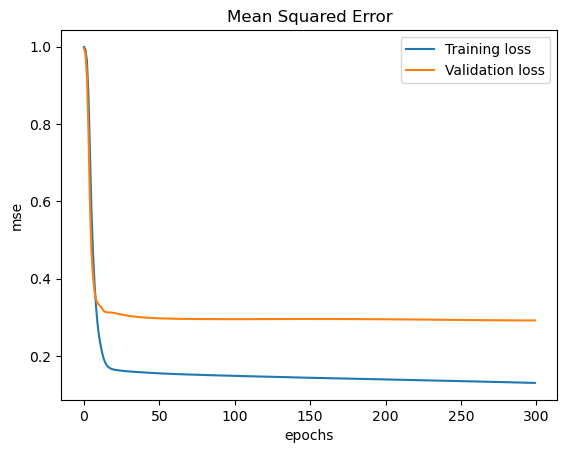

In [28]:
import matplotlib.pyplot as plt
plt.plot(GRU_hp_1.history['mean_squared_error'], label = 'Training loss')
plt.plot(GRU_hp_1.history['val_mean_squared_error'], label = 'Validation loss')
plt.title('Mean Squared Error')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()

In [29]:
#### find the best epoch by looking in to the validation loss

val_loss_per_epoch = GRU_hp_1.history['val_loss']   

#### 'val_loss' should align with the objective function used when applying 'tuner.search' (both should be loss or both accuracy)

best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1

print('Best epoch: %d' % (best_epoch,))

Best epoch: 298


In [30]:
### Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model

hypermodel.fit(X_train, y_train, epochs= best_epoch, verbose = 1, validation_data=(X_val, y_val), shuffle = False) 

# hypermodel.fit(X_train, y_train, epochs= 250, verbose = 1, validation_data=(X_val, y_val), shuffle = False) 


Epoch 1/298
64/64 [==============================] - 8s 22ms/step - loss: 0.9990 - mean_squared_error: 0.9990 - val_loss: 0.9947 - val_mean_squared_error: 0.9947
Epoch 2/298
64/64 [==============================] - 1s 8ms/step - loss: 0.9923 - mean_squared_error: 0.9923 - val_loss: 0.9801 - val_mean_squared_error: 0.9801
Epoch 3/298
64/64 [==============================] - 1s 8ms/step - loss: 0.9620 - mean_squared_error: 0.9620 - val_loss: 0.9215 - val_mean_squared_error: 0.9215
Epoch 4/298
64/64 [==============================] - 1s 8ms/step - loss: 0.8740 - mean_squared_error: 0.8740 - val_loss: 0.7781 - val_mean_squared_error: 0.7781
Epoch 5/298
64/64 [==============================] - 1s 8ms/step - loss: 0.7231 - mean_squared_error: 0.7231 - val_loss: 0.5919 - val_mean_squared_error: 0.5919
Epoch 6/298
64/64 [==============================] - 0s 8ms/step - loss: 0.5735 - mean_squared_error: 0.5735 - val_loss: 0.4689 - val_mean_squared_error: 0.4689
Epoch 7/298
64/64 [==============

64/64 [==============================] - 1s 9ms/step - loss: 0.1548 - mean_squared_error: 0.1548 - val_loss: 0.2971 - val_mean_squared_error: 0.2971
Epoch 52/298
64/64 [==============================] - 1s 10ms/step - loss: 0.1546 - mean_squared_error: 0.1546 - val_loss: 0.2970 - val_mean_squared_error: 0.2970
Epoch 53/298
64/64 [==============================] - 1s 12ms/step - loss: 0.1545 - mean_squared_error: 0.1545 - val_loss: 0.2969 - val_mean_squared_error: 0.2969
Epoch 54/298
64/64 [==============================] - 1s 12ms/step - loss: 0.1543 - mean_squared_error: 0.1543 - val_loss: 0.2968 - val_mean_squared_error: 0.2968
Epoch 55/298
64/64 [==============================] - 1s 11ms/step - loss: 0.1541 - mean_squared_error: 0.1541 - val_loss: 0.2967 - val_mean_squared_error: 0.2967
Epoch 56/298
64/64 [==============================] - 1s 10ms/step - loss: 0.1539 - mean_squared_error: 0.1539 - val_loss: 0.2965 - val_mean_squared_error: 0.2965
Epoch 57/298
64/64 [================

64/64 [==============================] - 1s 9ms/step - loss: 0.1483 - mean_squared_error: 0.1483 - val_loss: 0.2950 - val_mean_squared_error: 0.2950
Epoch 102/298
64/64 [==============================] - 0s 6ms/step - loss: 0.1483 - mean_squared_error: 0.1483 - val_loss: 0.2951 - val_mean_squared_error: 0.2951
Epoch 103/298
64/64 [==============================] - 0s 7ms/step - loss: 0.1481 - mean_squared_error: 0.1481 - val_loss: 0.2950 - val_mean_squared_error: 0.2950
Epoch 104/298
64/64 [==============================] - 0s 7ms/step - loss: 0.1480 - mean_squared_error: 0.1480 - val_loss: 0.2950 - val_mean_squared_error: 0.2950
Epoch 105/298
64/64 [==============================] - 0s 7ms/step - loss: 0.1480 - mean_squared_error: 0.1480 - val_loss: 0.2951 - val_mean_squared_error: 0.2951
Epoch 106/298
64/64 [==============================] - 0s 7ms/step - loss: 0.1478 - mean_squared_error: 0.1478 - val_loss: 0.2950 - val_mean_squared_error: 0.2950
Epoch 107/298
64/64 [===============

64/64 [==============================] - 0s 6ms/step - loss: 0.1435 - mean_squared_error: 0.1435 - val_loss: 0.2954 - val_mean_squared_error: 0.2954
Epoch 152/298
64/64 [==============================] - 0s 6ms/step - loss: 0.1434 - mean_squared_error: 0.1434 - val_loss: 0.2954 - val_mean_squared_error: 0.2954
Epoch 153/298
64/64 [==============================] - 0s 6ms/step - loss: 0.1433 - mean_squared_error: 0.1433 - val_loss: 0.2954 - val_mean_squared_error: 0.2954
Epoch 154/298
64/64 [==============================] - 0s 6ms/step - loss: 0.1432 - mean_squared_error: 0.1432 - val_loss: 0.2954 - val_mean_squared_error: 0.2954
Epoch 155/298
64/64 [==============================] - 0s 6ms/step - loss: 0.1431 - mean_squared_error: 0.1431 - val_loss: 0.2954 - val_mean_squared_error: 0.2954
Epoch 156/298
64/64 [==============================] - 0s 7ms/step - loss: 0.1430 - mean_squared_error: 0.1430 - val_loss: 0.2954 - val_mean_squared_error: 0.2954
Epoch 157/298
64/64 [===============

64/64 [==============================] - 0s 6ms/step - loss: 0.1392 - mean_squared_error: 0.1392 - val_loss: 0.2948 - val_mean_squared_error: 0.2948
Epoch 202/298
64/64 [==============================] - 0s 7ms/step - loss: 0.1388 - mean_squared_error: 0.1388 - val_loss: 0.2945 - val_mean_squared_error: 0.2945
Epoch 203/298
64/64 [==============================] - 0s 6ms/step - loss: 0.1390 - mean_squared_error: 0.1390 - val_loss: 0.2947 - val_mean_squared_error: 0.2947
Epoch 204/298
64/64 [==============================] - 0s 7ms/step - loss: 0.1387 - mean_squared_error: 0.1387 - val_loss: 0.2945 - val_mean_squared_error: 0.2945
Epoch 205/298
64/64 [==============================] - 0s 7ms/step - loss: 0.1388 - mean_squared_error: 0.1388 - val_loss: 0.2947 - val_mean_squared_error: 0.2947
Epoch 206/298
64/64 [==============================] - 1s 7ms/step - loss: 0.1385 - mean_squared_error: 0.1385 - val_loss: 0.2943 - val_mean_squared_error: 0.2943
Epoch 207/298
64/64 [===============

64/64 [==============================] - 0s 6ms/step - loss: 0.1347 - mean_squared_error: 0.1347 - val_loss: 0.2930 - val_mean_squared_error: 0.2930
Epoch 252/298
64/64 [==============================] - 0s 6ms/step - loss: 0.1345 - mean_squared_error: 0.1345 - val_loss: 0.2927 - val_mean_squared_error: 0.2927
Epoch 253/298
64/64 [==============================] - 0s 6ms/step - loss: 0.1346 - mean_squared_error: 0.1346 - val_loss: 0.2929 - val_mean_squared_error: 0.2929
Epoch 254/298
64/64 [==============================] - 0s 5ms/step - loss: 0.1343 - mean_squared_error: 0.1343 - val_loss: 0.2927 - val_mean_squared_error: 0.2927
Epoch 255/298
64/64 [==============================] - 0s 5ms/step - loss: 0.1343 - mean_squared_error: 0.1343 - val_loss: 0.2926 - val_mean_squared_error: 0.2926
Epoch 256/298
64/64 [==============================] - 0s 5ms/step - loss: 0.1343 - mean_squared_error: 0.1343 - val_loss: 0.2928 - val_mean_squared_error: 0.2928
Epoch 257/298
64/64 [===============

## f. Test best model

In [31]:

eval_result = model.evaluate(X_test, y_test)

print("[test loss, test accuracy]:", eval_result)

14/14 [==============================] - 0s 4ms/step - loss: 0.2459 - mean_squared_error: 0.2459
[test loss, test accuracy]: [0.2458837330341339, 0.24588371813297272]


In [32]:
Y_pred = hypermodel.predict(X_test)   ### results from the hypermodel are giving fluctuating results
# Y_pred = model.predict(X_test)   #### this is giving better result(more stable)

14/14 [==============================] - 1s 4ms/step


In [33]:
Y_pred

array([[[-4.35696602e-01]],

       [[-4.35695559e-01]],

       [[-4.35697675e-01]],

       [[-4.35697556e-01]],

       [[-4.35697675e-01]],

       [[-4.35697675e-01]],

       [[-4.35697675e-01]],

       [[-4.35697675e-01]],

       [[-4.35697675e-01]],

       [[-4.35697675e-01]],

       [[-4.35697675e-01]],

       [[-4.35697675e-01]],

       [[-4.35697675e-01]],

       [[-4.35697675e-01]],

       [[-4.35630709e-01]],

       [[-2.57776976e-01]],

       [[-1.39655337e-01]],

       [[-2.14053541e-01]],

       [[-2.24974543e-01]],

       [[-1.26564950e-01]],

       [[ 2.20549688e-01]],

       [[ 5.04377931e-02]],

       [[-1.38719529e-01]],

       [[-2.50140429e-01]],

       [[-2.02699289e-01]],

       [[-1.06060565e-01]],

       [[ 1.13124475e-01]],

       [[ 4.88045037e-01]],

       [[ 9.34058964e-01]],

       [[ 1.90561056e+00]],

       [[ 1.14036918e+00]],

       [[ 8.13157141e-01]],

       [[ 1.20872426e+00]],

       [[ 6.81281567e-01]],

       [[ 2.89

In [34]:
print(Y_pred.shape)

Y_pred = Y_pred.reshape(436,1)

(436, 1, 1)


In [35]:
# Y_pred[:,-1]
Y_pred

array([[-4.35696602e-01],
       [-4.35695559e-01],
       [-4.35697675e-01],
       [-4.35697556e-01],
       [-4.35697675e-01],
       [-4.35697675e-01],
       [-4.35697675e-01],
       [-4.35697675e-01],
       [-4.35697675e-01],
       [-4.35697675e-01],
       [-4.35697675e-01],
       [-4.35697675e-01],
       [-4.35697675e-01],
       [-4.35697675e-01],
       [-4.35630709e-01],
       [-2.57776976e-01],
       [-1.39655337e-01],
       [-2.14053541e-01],
       [-2.24974543e-01],
       [-1.26564950e-01],
       [ 2.20549688e-01],
       [ 5.04377931e-02],
       [-1.38719529e-01],
       [-2.50140429e-01],
       [-2.02699289e-01],
       [-1.06060565e-01],
       [ 1.13124475e-01],
       [ 4.88045037e-01],
       [ 9.34058964e-01],
       [ 1.90561056e+00],
       [ 1.14036918e+00],
       [ 8.13157141e-01],
       [ 1.20872426e+00],
       [ 6.81281567e-01],
       [ 2.89839506e-01],
       [ 6.92224562e-01],
       [ 1.34434354e+00],
       [ 1.56012908e-01],
       [-6.8

In [36]:
y_test

array([[-5.98808761e-01],
       [-6.00386034e-01],
       [-6.00386034e-01],
       [-5.98808761e-01],
       [-5.99860276e-01],
       [-5.97231489e-01],
       [-5.98808761e-01],
       [-6.00386034e-01],
       [-6.00386034e-01],
       [-6.01437548e-01],
       [-6.01963306e-01],
       [-6.03540578e-01],
       [-6.04592093e-01],
       [-6.05117850e-01],
       [-6.04592093e-01],
       [-5.86716341e-01],
       [-5.86716341e-01],
       [-5.60428470e-01],
       [-5.71995133e-01],
       [-5.78829979e-01],
       [-5.79355737e-01],
       [-5.74623920e-01],
       [-3.87454278e-01],
       [-4.44761837e-01],
       [-5.17316361e-01],
       [-4.87348188e-01],
       [-3.65372467e-01],
       [ 1.58807682e-01],
       [ 1.19901633e-01],
       [ 7.29254483e-01],
       [ 1.45663746e-01],
       [ 1.55653137e-01],
       [ 1.25159207e-01],
       [-3.43290655e-01],
       [-3.74836100e-01],
       [ 6.06753004e-01],
       [ 9.67683062e-02],
       [-4.00072456e-01],
       [-4.8

In [37]:
y_test.shape

(436, 1)

In [38]:
print(y_test[:,:-1].shape)   
print(y_test[:,1:2].shape)

(436, 0)
(436, 0)


## Evaluation metics

In [39]:
###nse

import hydroeval as he
nse = he.evaluator(he.nse, Y_pred, y_test )
print(nse)

[0.7538858]


In [40]:
##rmse
rmse = he.evaluator(he.rmse, Y_pred, y_test )
print(rmse)

[0.49552973]


In [41]:
###logrmse
from sklearn.metrics import mean_squared_error
#### log of predicted values
y_pred_lg = np.log1p(Y_pred)

#### log of test values
y_test_lg = np.log1p(y_test)


In [42]:
##calculate mse
mse = mean_squared_error(y_pred_lg, y_test_lg)
rmse_lg = np.sqrt(mse)   
print(rmse_lg)

0.4014307590819161


## g. plot

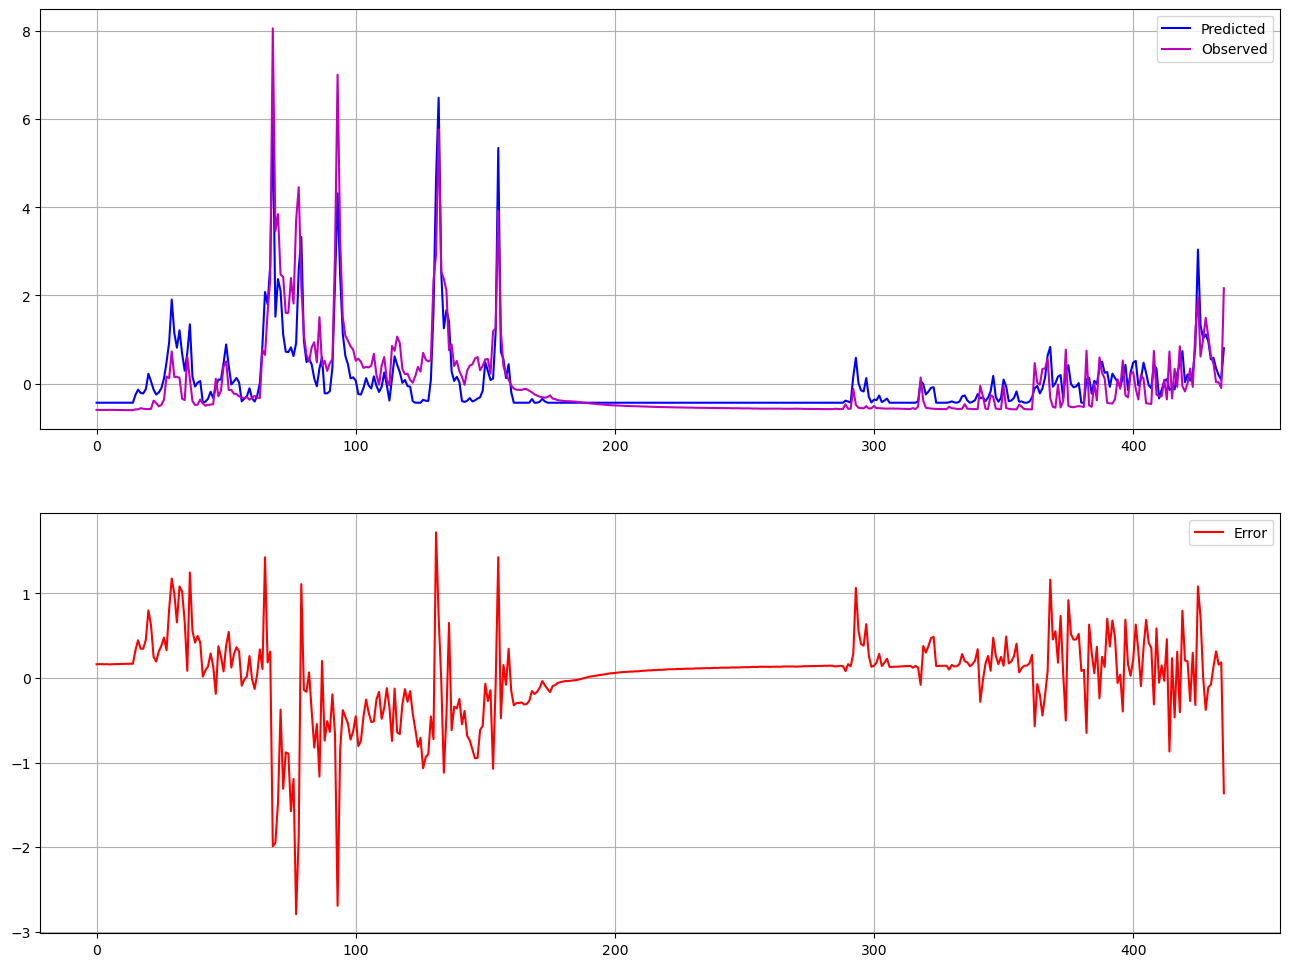

In [43]:
import matplotlib.pyplot as plt
# plt.plot(Q_pred)
# plt.plot(y_test)

plt.figure(figsize = (16, 12))

plt.subplot(2, 1, 1)

plt.plot(Y_pred,'b', label = "Predicted")

plt.plot(y_test[:,-1], 'm',  label = "Observed")  

plt.legend()
plt.grid()

plt.subplot(2,1,2)

plt.plot(Y_pred - y_test,'r', label = "Error")

plt.legend()

plt.grid()

##  save_model

## h. Denormalize the data

In [44]:
#### Original data
df_train_norm

# df_val_f

# df_test_f

,Rt,Rt_1,Rt_2,Rt_3,Rt_4,Rt_5,Qt
0,-0.306768,1.345488,-0.120634,0.191968,-0.258026,1.555244,0.500865
1,-0.366809,-0.307482,1.345417,-0.120909,0.191917,-0.258825,0.091390
2,1.378816,-0.367498,-0.307591,1.345176,-0.120965,0.190866,-0.017104
3,2.156268,1.377410,-0.367608,-0.307870,1.345145,-0.121841,1.417809
4,0.056074,2.154542,1.377339,-0.367889,-0.307929,1.343448,0.798347
...,...,...,...,...,...,...,...
2035,-0.366809,-0.367498,-0.367608,-0.367889,-0.367949,-0.368686,-0.494825
2036,-0.366809,-0.367498,-0.367608,-0.367889,-0.367949,-0.368686,-0.494825
2037,-0.362091,-0.367498,-0.367608,-0.367889,-0.367949,-0.368686,-0.494825
2038,-0.327215,-0.362781,-0.367608,-0.367889,-0.367949,-0.368686,-0.496575


In [45]:
### normalized data after model training
Y_pred    #### model out put
# y_obser = y_test[:,-1:]      ## observed discharge

array([[-4.35696602e-01],
       [-4.35695559e-01],
       [-4.35697675e-01],
       [-4.35697556e-01],
       [-4.35697675e-01],
       [-4.35697675e-01],
       [-4.35697675e-01],
       [-4.35697675e-01],
       [-4.35697675e-01],
       [-4.35697675e-01],
       [-4.35697675e-01],
       [-4.35697675e-01],
       [-4.35697675e-01],
       [-4.35697675e-01],
       [-4.35630709e-01],
       [-2.57776976e-01],
       [-1.39655337e-01],
       [-2.14053541e-01],
       [-2.24974543e-01],
       [-1.26564950e-01],
       [ 2.20549688e-01],
       [ 5.04377931e-02],
       [-1.38719529e-01],
       [-2.50140429e-01],
       [-2.02699289e-01],
       [-1.06060565e-01],
       [ 1.13124475e-01],
       [ 4.88045037e-01],
       [ 9.34058964e-01],
       [ 1.90561056e+00],
       [ 1.14036918e+00],
       [ 8.13157141e-01],
       [ 1.20872426e+00],
       [ 6.81281567e-01],
       [ 2.89839506e-01],
       [ 6.92224562e-01],
       [ 1.34434354e+00],
       [ 1.56012908e-01],
       [-6.8

In [46]:
def denormalize(data, original_data, type='min_max'):   ### default is min-max in this case(there is no reason behind this)

    if type == 'min_max':
        min = np.min(original_data)
        max = np.max(original_data)
        data = data * (max - min) + min
    elif type == 'z_score':
        mean = np.mean(original_data)
        std = np.std(original_data)
        data = data * std + mean
    elif type == 'max':                
        max = np.max(original_data)
        data = data * max
    else:
        raise ValueError("Invalid normalization type. Choose either 'max', 'min_max', or 'z_score'.")
    return data

In [47]:
Y_observ_unnorm = df_test['Qt']

In [48]:
Y_observ_unnorm = Y_observ_unnorm.to_numpy()

###  denormalized predicted discharge

In [49]:
### Standard denormalization (becasue we used standard(z-score) in this experiment)

Y_pred_denorm = denormalize(Y_pred, Y_observ_unnorm, type='z_score')

In [50]:
print(Y_pred_denorm)
print(Y_pred_denorm.shape)

[[  43.719315]
 [  43.719513]
 [  43.719116]
 [  43.71914 ]
 [  43.719116]
 [  43.719116]
 [  43.719116]
 [  43.719116]
 [  43.719116]
 [  43.719116]
 [  43.719116]
 [  43.719116]
 [  43.719116]
 [  43.719116]
 [  43.731834]
 [  77.52112 ]
 [  99.96228 ]
 [  85.82785 ]
 [  83.75304 ]
 [ 102.44924 ]
 [ 168.39531 ]
 [ 136.07684 ]
 [ 100.140076]
 [  78.97194 ]
 [  87.98497 ]
 [ 106.34474 ]
 [ 147.98628 ]
 [ 219.21503 ]
 [ 303.95032 ]
 [ 488.52914 ]
 [ 343.14587 ]
 [ 280.98096 ]
 [ 356.1322  ]
 [ 255.92679 ]
 [ 181.55923 ]
 [ 258.00577 ]
 [ 381.89764 ]
 [ 156.13438 ]
 [ 113.56756 ]
 [ 130.18208 ]
 [ 137.41423 ]
 [  43.731636]
 [  48.541466]
 [  60.72869 ]
 [  91.05784 ]
 [  63.521187]
 [ 111.54264 ]
 [ 143.23517 ]
 [ 143.79912 ]
 [ 214.21443 ]
 [ 295.16718 ]
 [ 202.12703 ]
 [ 122.45274 ]
 [ 135.79364 ]
 [ 150.61288 ]
 [ 131.03801 ]
 [  49.36383 ]
 [  61.320152]
 [  71.30032 ]
 [ 105.9688  ]
 [  62.492607]
 [  48.734695]
 [  75.10631 ]
 [ 128.28773 ]
 [ 292.34076 ]
 [ 521.15216 ]
 [ 468.679

### denormalized Observed discharge

In [51]:
len(y_test)

436

In [52]:
Y_obser_denorm = denormalize(y_test, Y_observ_unnorm, type='z_score')

In [53]:
Y_obser_denorm 

array([[  12.73068793],
       [  12.43103217],
       [  12.43103217],
       [  12.73068793],
       [  12.53091742],
       [  13.0303437 ],
       [  12.73068793],
       [  12.43103217],
       [  12.43103217],
       [  12.23126166],
       [  12.1313764 ],
       [  11.83172063],
       [  11.63195012],
       [  11.53206487],
       [  11.63195012],
       [  15.0280488 ],
       [  15.0280488 ],
       [  20.02231157],
       [  17.82483595],
       [  16.52632763],
       [  16.42644238],
       [  17.32540967],
       [  52.88456055],
       [  41.99706773],
       [  28.2129025 ],
       [  33.90636205],
       [  57.07974127],
       [ 156.66534078],
       [ 149.27383189],
       [ 265.04084274],
       [ 154.16820939],
       [ 156.06602924],
       [ 150.27268444],
       [  61.27492199],
       [  55.28180668],
       [ 241.76757826],
       [ 144.87888065],
       [  50.48731442],
       [  33.90636205],
       [  35.50452613],
       [  57.57916755],
       [  40.498

# Plot the denomalized data

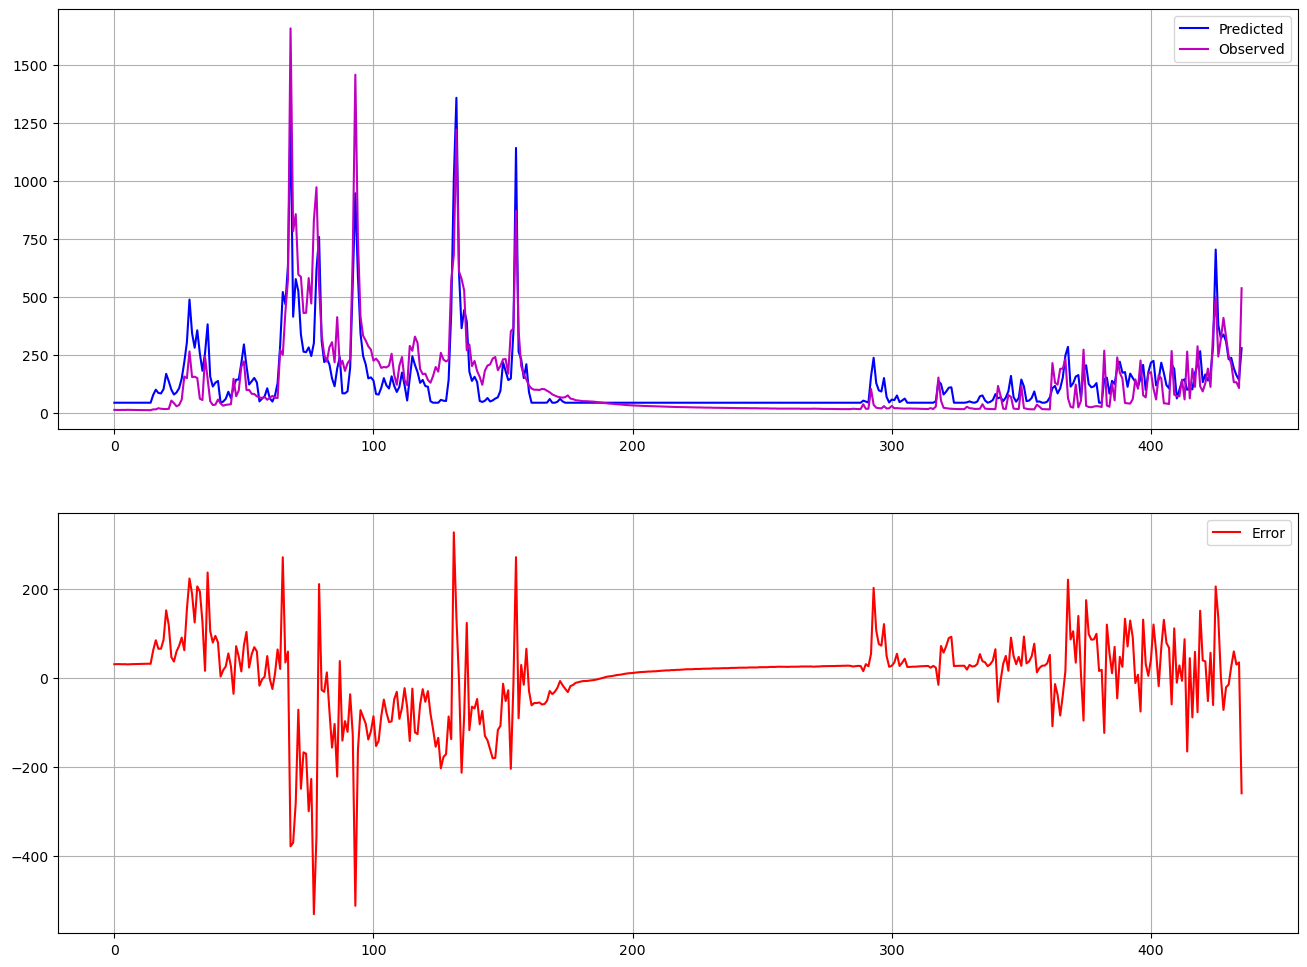

In [54]:
plt.figure(figsize = (16, 12))

plt.subplot(2, 1, 1)

plt.plot(Y_pred_denorm,'b', label = "Predicted")

plt.plot(Y_obser_denorm , 'm',  label = "Observed")  

plt.legend()
plt.grid()

plt.subplot(2,1,2)

plt.plot(Y_pred_denorm - Y_obser_denorm ,'r', label = "Error")

plt.legend()

plt.grid()

### NSE after denormalization

In [55]:
nse_d = he.evaluator(he.nse, Y_pred_denorm[:,-1] , Y_obser_denorm  )
print(nse_d)

[0.7538858]


### RMSE after denormalization (in m3/sec)

In [56]:
#### rmse in m3/sec
rmse_d = he.evaluator(he.rmse, Y_pred_denorm[:,-1], Y_obser_denorm)
print(rmse_d)    ### 

[94.1424928]
